In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from scipy.integrate import quad
from scipy.special import erf



0.9486445066272415 4 4
0.9734618235995288 4.08 4
0.998775486911262 4.1616 4


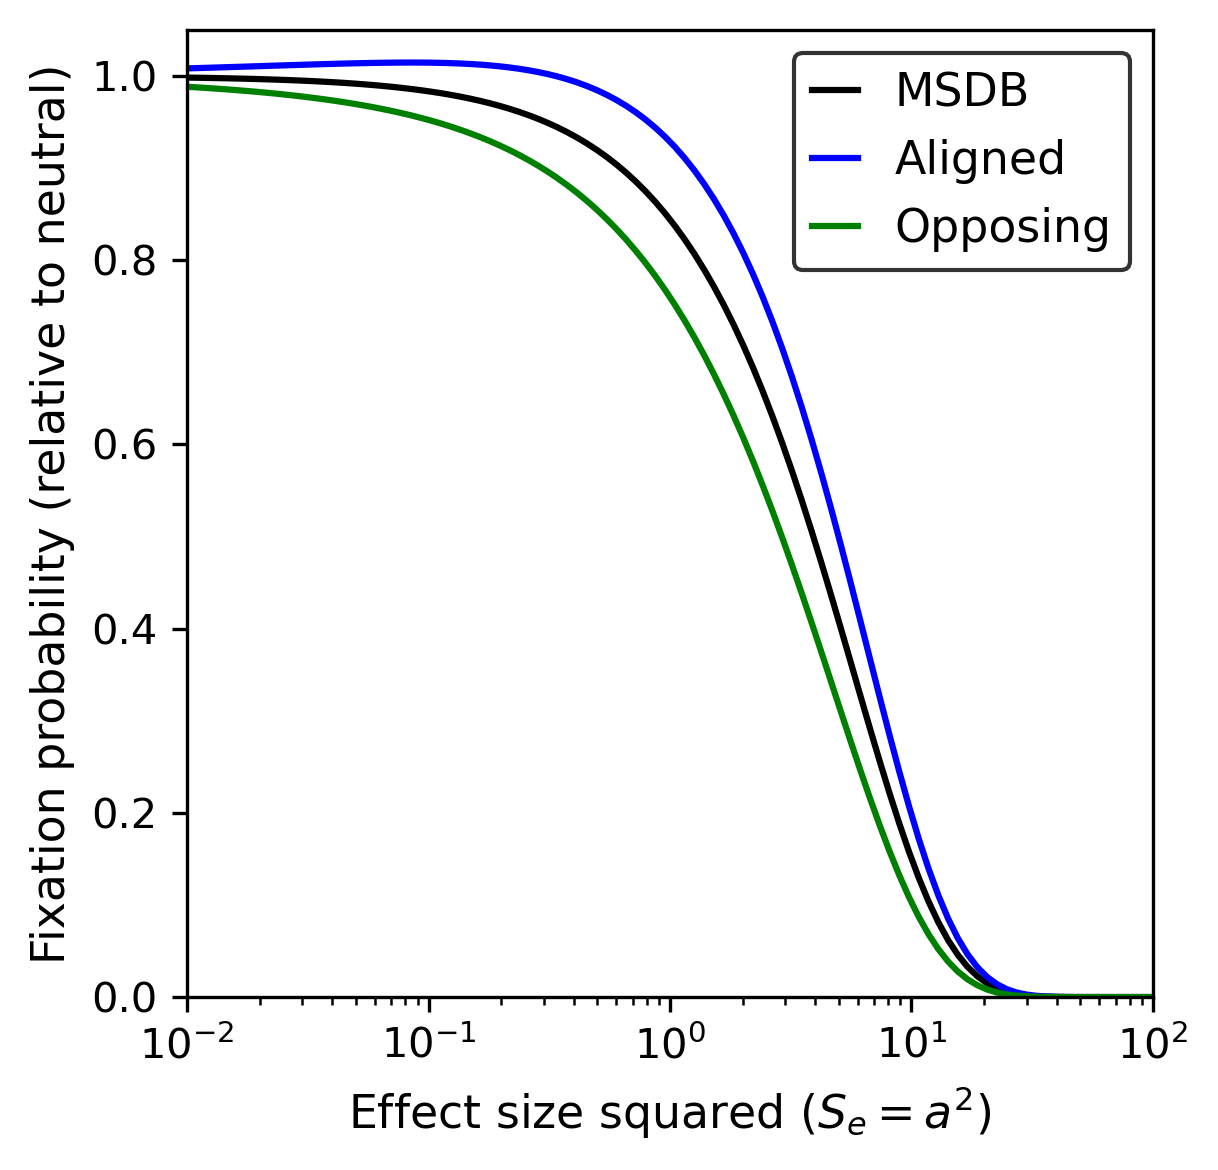

In [31]:
### FIGURE 1: Fixation probability for aligned and opposing alleles compared to the fixation probability at steady state relative to the fixation probability of neutral alleles ###
def fixation_prob_allele_given_x(a,x,N):
    return (erf(a/2)-erf(a/2*(1-2*x)))/(2*erf(a/2))

def variance_star(a,x,N):
    return 2*a**2*x*(1-x)

def folded_sojourn_time(a,x,N):
    if x < 1/(2*N):
        factor = 2*N
    else:
        factor = 1/x
    
    return factor * 2 * np.exp(-variance_star(a,x,N)/2) / (1-x)

def fixation_prob_steady_state(a,N):
    # integrand = lambda x: folded_sojourn_time(a,x,N) * fixation_prob_allele_given_x(a,x,N)
    # integral, error = quad(integrand, 0,1/2,points=[1/(2*N)])
    integral = fixation_prob_allele_given_x(a,1/(2*N),N)
    return integral

def frequency_after_shift(a,N,x,shift,Va):
    change = shift * a * x * (1-x) / Va
    new_x = x + change
    if new_x < 0:
        new_x = 0
    if new_x > 1:
        new_x = 1
    return new_x
    
def fixation_prob_shift(a,N,shift,Va):
    # integrand = lambda x: folded_sojourn_time(a,x,N) * fixation_prob_allele_given_x(a,frequency_after_shift(a,N,x,shift,Va),N)
    # integral, error = quad(integrand, 0,1/2,points=[1/(2*N)])
    integral = fixation_prob_allele_given_x(a,frequency_after_shift(a,N,1/(2*N),shift,Va),N)
    return integral

def plot_fixation_prob(ax,N,shift,Va):
    S_values = np.logspace(-2,2,100)
    a_values = np.sqrt(S_values)
    fp_steady = [fixation_prob_steady_state(a,N) for a in a_values]
    fp_aligned = [fixation_prob_shift(a,N,shift,Va) for a in a_values]
    fp_opposing = [fixation_prob_shift(a,N,-shift,Va) for a in a_values]
    fp_neutral = fixation_prob_steady_state(a=0.0001,N=N)
    ax.plot(S_values,[fp/fp_neutral for fp in fp_steady],label='MSDB',color='black')
    ax.plot(S_values,[fp/fp_neutral for fp in fp_aligned],label='Aligned',color='blue')
    ax.plot(S_values,[fp/fp_neutral for fp in fp_opposing],label='Opposing',color='green')
    ax.set_xscale('log')
    ax.set_ylabel('Fixation probability (relative to neutral)',fontsize=11)
    ax.set_xlabel(r'Effect size squared ($S_e=a^2$)',fontsize=11)
    ax.set_xlim(0.01,100)
    ax.set_ylim(0,1.05)
    ax.legend(edgecolor='black',loc='upper right',fontsize=11,handlelength=1)

def create_square_figure(width,height,dpi,func,*args,**kwargs):
    fig = plt.figure(figsize=(width,height),dpi=dpi)
    ax = fig.add_subplot(1,1,1)
    func(ax=ax,*args,**kwargs)
    
    plt.tight_layout()
    # check if figure axes is square
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width_1, height_1 = bbox.width, bbox.height
    print(width_1/height_1,width,height)
    # if not square, adjust figure size and try again
    if width_1/height_1 < 0.98:
        new_width = width * 1.02
        new_height = height
        plt.close(fig)
        return create_square_figure(new_width,new_height,dpi,func,*args,**kwargs)
    elif width_1/height_1 > 1.02:
        new_width = width
        new_height = height * 1.02
        plt.close(fig)
        return create_square_figure(new_width,new_height,dpi,func,*args,**kwargs)
    else:
        return fig, ax
        
fig, ax = create_square_figure(4,4,300,plot_fixation_prob,N=5000,shift=40,Va=400)
# check if figure axes is square
bbox = ax.get_position().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
plt.savefig('../Figures/Supplement_Figure_3.png',dpi=300)
